# House prices regression pt.2

1) Data preprocessing iteration: Manually iterate to find a pipeline of feature engineering, feature selection and modeling that performs achieves a decent cross validation metric score and is production friendly.
    - Baseline model
    - Preprocess towards linear model. Test on both linear and tree model.
    - Preprocess towards non-linear model if tree model looked more promising in the previous step
2) Modeling and Hyperparameter optimisation: Run hyperparameter tuning to squeeze out some more performance from the models

In [1]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
import preprocessors as pp
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine import selection as sel
from feature_engine import transformation as trans
from feature_engine import wrappers as wrap

# modeling
import random
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import optuna

SEED = 0

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../data/train.csv", index_col=False)

In [3]:
train, test = train_test_split(data, test_size=0.1, random_state=SEED)

In [4]:
X_train, y_train, X_test, y_test = train.drop('SalePrice', axis=1), train['SalePrice'], test.drop('SalePrice', axis=1), test['SalePrice']

In [5]:
X_test.dtypes.sort_index().reset_index().to_csv('types.csv')

In [6]:
def plot_rmse(score_dict):
    score_df = pd.DataFrame(score_dict)
    score_df[['test_score', 'train_score']] = score_df[['test_score', 'train_score']].apply(lambda x: np.sqrt(-x))
    score_df[['train_score', 'test_score']].plot(kind='box', figsize=(5, 4))

## Baseline

mean: 0.4021666517932202


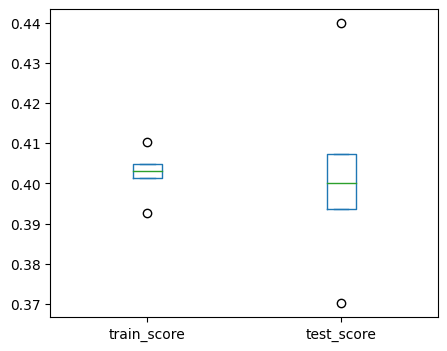

In [7]:
dummy = DummyRegressor().fit(X_train, y_train)
dummy_score = cross_validate(dummy, X_train, np.log(1+y_train), 
                             scoring='neg_mean_squared_error',
                             return_train_score=True)

print(f"mean: {np.sqrt(-dummy_score['test_score']).mean()}")
plot_rmse(dummy_score)

## Data cleaning

In [8]:
cat_vars = [var for var in train.columns if train[var].dtype == 'object']
cat_vars += ['MSSubClass']

num_vars = [
    var for var in train.columns if var not in cat_vars and var != 'SalePrice' and var!= 'Id'
]
year_vars = [var for var in num_vars if 'Yr' in var or 'Year' in var]

discrete_vars = [var for var in num_vars if (train[var].nunique() < 20) 
                 and var not in year_vars]

cont_vars = [var for var in num_vars if var not in discrete_vars and var not in year_vars]

discrete_vars.remove('MoSold')
num_vars.remove('MoSold')
cat_vars.append('MoSold')

binarise_vars = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal'
]

In [9]:
# impute

# numerical
impute_zero_vars = ['MasVnrArea']
impute_from_other_vars = ['GarageYrBlt']
impute_median_vars = [var for var in num_vars if var not in impute_zero_vars+impute_from_other_vars]


# categorical
impute_none_vars = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]
             
impute_mode_vars = [var for var in cat_vars if var not in impute_none_vars]

In [10]:
train[impute_zero_vars+impute_from_other_vars+impute_median_vars] = train[impute_zero_vars+impute_from_other_vars+impute_median_vars].astype('float')
train[impute_none_vars+impute_mode_vars] = train[impute_none_vars+impute_mode_vars].astype('object')

In [11]:
fe1_pipeline = Pipeline([
    ('impute_none', mdi.CategoricalImputer(fill_value='None', variables=impute_none_vars, return_object=True, ignore_format=True)),
    ('impute_mode', mdi.CategoricalImputer(fill_value='Missing', variables=impute_mode_vars, return_object=True, ignore_format=True)),
    ('impute_zero', mdi.ArbitraryNumberImputer(arbitrary_number=0, variables=impute_zero_vars)),
    ('impute_median', mdi.MeanMedianImputer(variables=impute_median_vars)),
    ('impute_from_other_vars', pp.UseOtherColumnsImputer(variables=impute_from_other_vars, references=['YearBuilt'])),
    ('create', pp.FeatureCreator())
])

Test the preprocessing

In [12]:
train_cleaned = fe1_pipeline.fit_transform(train)

In [13]:
train_cleaned.isna().sum().sum()

0

In [14]:
train_cleaned.dtypes.value_counts()

object     45
float64    39
int64       2
int32       1
Name: count, dtype: int64

## Data transformation

In [15]:
discrete_vars_dt = discrete_vars + ['TotBathrooms', 'TotRms']
cont_vars_dt =  cont_vars + ['TotalSF', 'TotPorchSF', 'TotLivArea'] + year_vars[:-1] # exclude yrsold
cat_vars_dt = cat_vars + ['IsNew']

In [16]:
num_vars_dt = discrete_vars_dt+cont_vars_dt

In [17]:
num_vars_skewed_dt = train_cleaned[num_vars_dt].apply(skew)
num_vars_skewed_dt = num_vars_skewed_dt[num_vars_skewed_dt > 0.75]
num_vars_skewed_dt = num_vars_skewed_dt.index.tolist()

In [18]:
cont_vars_skewed_dt = train_cleaned[cont_vars_dt].apply(skew)
cont_vars_skewed_dt = cont_vars_skewed_dt[cont_vars_skewed_dt > 0.75]
cont_vars_skewed_dt = cont_vars_skewed_dt.index.tolist()

cont_vars_less_skewed_dt = [
    var for var in cont_vars_dt if var not in cont_vars_skewed_dt
]

In [19]:
[var for var in train_cleaned.columns if var not in discrete_vars_dt+cont_vars_skewed_dt+cont_vars_less_skewed_dt+cat_vars_dt]

['Id', 'YrSold', 'SalePrice']

Test the preprocessing

In [20]:
# fe2_pipeline = Pipeline([    
#     ('log', pp.Log1P(variables=cont_vars_skewed_dt)),
#     ('binariser', pp.Binariser(binarise_vars)),
#     ('rare_encoder', ce.RareLabelEncoder(tol=0.05, n_categories=1, variables=cat_vars_dt+discrete_vars_dt, ignore_format=True)), # tol is a hyperp
#     ('ohe', ce.OneHotEncoder(variables=cat_vars_dt+discrete_vars_dt, ignore_format=True)),
#     ('scale', wrap.SklearnTransformerWrapper(StandardScaler(), variables=cont_vars_dt))
# ])

In [21]:
# total_pipeline = Pipeline([
#     ('fe1', fe1_pipeline),
#     ('fe2', fe2_pipeline)
# ])

In [22]:
# # 94 in total, as expected
# train_after_fe = total_pipeline.fit_transform(train)

In [23]:
# train_after_fe[cont_less_skewed_vars].hist(figsize=(15, 15));

In [24]:
# train_after_fe[cont_skewed_vars].hist(figsize=(10, 5));

## Feature selection

1) Drop id, yrsold
2) Remove constants, duplicates
3) Select variables via importance

In [25]:
# fs_pipeline = Pipeline([
#     ('drop', sel.DropFeatures(['Id', 'YrSold'])),
#     ('constant', sel.DropConstantFeatures()),
#     ('duplicates', sel.DropDuplicateFeatures()),
#     ('correl', sel.SmartCorrelatedSelection(estimator=LinearRegression()))
# ])

In [26]:
# total_pipeline = Pipeline([
#     ('fe1', fe1_pipeline),
#     ('fe2', fe2_pipeline),
#     ('fs', fs_pipeline)
# ])

Test the preprocessing

In [27]:
# # works!
# tmp_total_pipe = total_pipeline.fit_transform(X_train, y_train)

## Feature engineering testing

Edit the pipeline whenever necessary to remove bugs or improve on baseline model(s) performance 

In [28]:
fc_pipeline = Pipeline([
    ('impute_none', mdi.CategoricalImputer(fill_value='None', variables=impute_none_vars, return_object=True, ignore_format=True)),
    ('impute_missing', mdi.CategoricalImputer(fill_value='Missing', variables=impute_mode_vars, return_object=True, ignore_format=True)),
    ('impute_zero', mdi.ArbitraryNumberImputer(arbitrary_number=0, variables=impute_zero_vars)),
    ('impute_median', mdi.MeanMedianImputer(variables=impute_median_vars)),
    ('impute_from_other_vars', pp.UseOtherColumnsImputer(variables=impute_from_other_vars, references=['YearBuilt'])),
    ('create', pp.FeatureCreator())
])

dt_pipeline = Pipeline([
    ('log', trans.LogCpTransformer(variables=cont_vars_skewed_dt, C=1)),
    ('binariser', pp.Binariser(binarise_vars)),
    ('rare_encoder', ce.RareLabelEncoder(tol=0.05, n_categories=1, variables=cat_vars_dt+discrete_vars_dt, ignore_format=True)), # tol is a hyperp
    ('ohe', ce.OneHotEncoder(variables=cat_vars_dt+discrete_vars_dt, ignore_format=True)),
    ('scale', wrap.SklearnTransformerWrapper(StandardScaler(), variables=cont_vars_dt))
])

fs_pipeline = Pipeline([
    ('drop', sel.DropFeatures(['Id', 'YrSold'])),
    ('constant', sel.DropConstantFeatures()),
    ('duplicates', sel.DropDuplicateFeatures()),
    ('correl', sel.SmartCorrelatedSelection(selection_method='model_performance', 
                                            estimator=LinearRegression(),
                                            scoring='neg_mean_squared_error'))
])

In [29]:
total_pipeline = Pipeline([
    ('fc', fc_pipeline),
    ('dt', dt_pipeline),
    ('fs', fs_pipeline)
])

In [30]:
X_train[impute_zero_vars+impute_from_other_vars+impute_median_vars] = X_train[impute_zero_vars+impute_from_other_vars+impute_median_vars].astype('float')
X_train[impute_none_vars+impute_mode_vars] = X_train[impute_none_vars+impute_mode_vars].astype('object')

In [31]:
# tmp = total_pipeline.fit_transform(X_train, y_train)

In [32]:
# tmp.isna().sum().sum()

In [33]:
# len(tmp.columns)

In [34]:
# tmp.sample(random_state=SEED)

Try out baselines first

mean: 0.1519281796614407


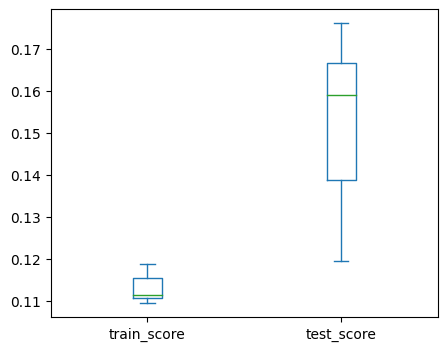

In [35]:
lr_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', LinearRegression())
])

lr_score = cross_validate(lr_pipeline, X_train, np.log(1+y_train),
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

print(f"mean: {np.sqrt(-lr_score['test_score']).mean()}")
plot_rmse(lr_score)

mean: 0.214779291709575


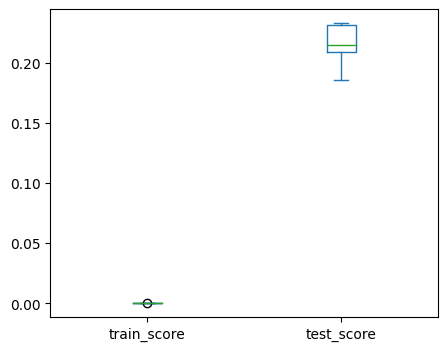

In [37]:
dt_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', DecisionTreeRegressor(random_state=0))
])

dt_score = cross_validate(dt_pipeline, X_train, np.log(1+y_train), 
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
plot_rmse(dt_score)
print(f"mean: {np.sqrt(-dt_score['test_score']).mean()}")

Let's try other models to improve on the baselines

mean: 0.14187721501768832


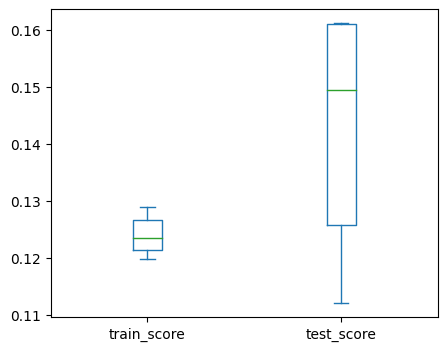

In [38]:
lasso_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', LassoCV(alphas = [1, 0.1, .01, 0.05, 0.001, 0.0005]))
])
lasso_score = cross_validate(lasso_pipeline, X_train, np.log(1+y_train),
                             scoring='neg_mean_squared_error',
                             return_train_score=True)
plot_rmse(lasso_score)
print(f"mean: {np.sqrt(-lasso_score['test_score']).mean()}")

mean: 0.14810671080921167


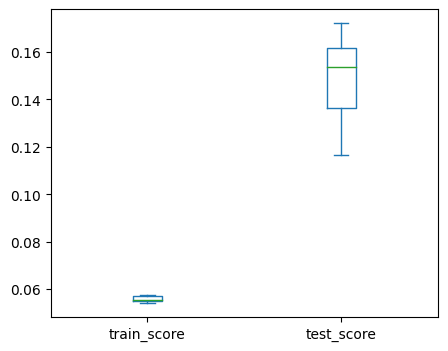

In [39]:
rf_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', RandomForestRegressor(random_state=0))
])

rf_score = cross_validate(rf_pipeline, X_train, np.log(1+y_train),
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
plot_rmse(rf_score)
print(f"mean: {np.sqrt(-rf_score['test_score']).mean()}")

mean: 0.1483047411161155


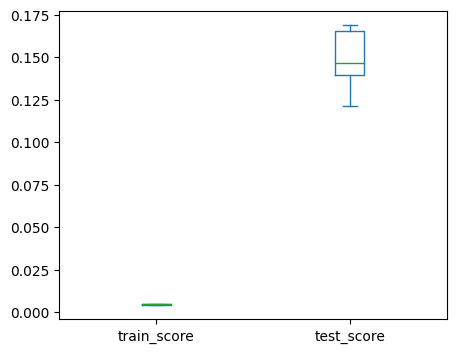

In [40]:
xgb_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', XGBRegressor(random_state=0))
])

xgb_score = cross_validate(xgb_pipeline, X_train, np.log(1+y_train),
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

plot_rmse(xgb_score)
print(f"mean: {np.sqrt(-xgb_score['test_score']).mean()}")

mean: 0.1401467973131102


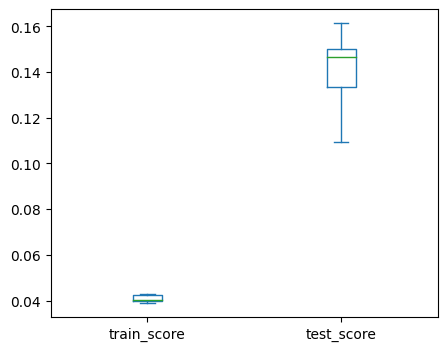

In [41]:
lgbm_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', LGBMRegressor(random_state=0))
])

lgbm_score = cross_validate(lgbm_pipeline, X_train, np.log(1+y_train),
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

plot_rmse(lgbm_score)
print(f"mean: {np.sqrt(-lgbm_score['test_score']).mean()}")

mean: 0.1363168032281074


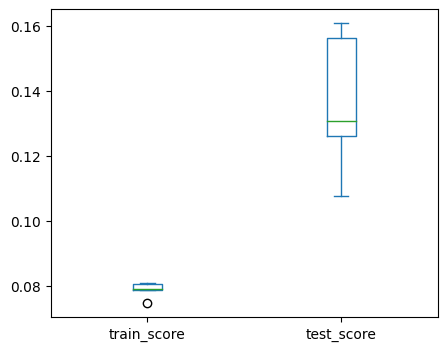

In [42]:
gbr_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', GradientBoostingRegressor(random_state=0))
])

gbr_score = cross_validate(gbr_pipeline, X_train, np.log(1+y_train),
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

plot_rmse(gbr_score)
print(f"mean: {np.sqrt(-gbr_score['test_score']).mean()}")

LGBM looks good so let's try optimising it.

## Pipeline simplification for tree modeling

In [43]:
fc_pipeline = Pipeline([
    ('impute_none', mdi.CategoricalImputer(fill_value='None', variables=impute_none_vars, return_object=True, ignore_format=True)),
    ('impute_missing', mdi.CategoricalImputer(fill_value='Missing', variables=impute_mode_vars, return_object=True, ignore_format=True)),
    ('impute_zero', mdi.ArbitraryNumberImputer(arbitrary_number=0, variables=impute_zero_vars)),
    ('impute_median', mdi.MeanMedianImputer(variables=impute_median_vars)),
    ('impute_from_other_vars', pp.UseOtherColumnsImputer(variables=impute_from_other_vars, references=['YearBuilt'])),
    ('create', pp.FeatureCreator())
])

dt_pipeline = Pipeline([
    # ('log', pp.Log1P(variables=cont_vars_skewed_dt)),
    ('binariser', pp.Binariser(binarise_vars)),
    ('rare_encoder', ce.RareLabelEncoder(tol=0.05, n_categories=1, variables=cat_vars_dt+discrete_vars_dt, ignore_format=True)), # tol is a hyperp
    ('cat_encoder', ce.OrdinalEncoder(encoding_method='ordered', variables=cat_vars_dt+discrete_vars_dt)), # encoding is hyperp
    # ('ohe', ce.OneHotEncoder(variables=cat_vars_dt+discrete_vars_dt, ignore_format=True)),
    # ('scale', wrap.SklearnTransformerWrapper(StandardScaler(), variables=cont_vars_dt))
])

fs_pipeline = Pipeline([
    ('drop', sel.DropFeatures(['Id', 'YrSold'])),
    ('constant', sel.DropConstantFeatures()),
    ('duplicates', sel.DropDuplicateFeatures()),
    ('correl', sel.SmartCorrelatedSelection(selection_method='model_performance', 
                                            estimator=DecisionTreeRegressor(random_state=SEED),
                                            scoring='neg_mean_squared_error'))
])

In [44]:
total_pipeline = Pipeline([
    ('fc', fc_pipeline),
    ('dt', dt_pipeline),
    ('fs', fs_pipeline)
])

mean: 0.13675470133873496


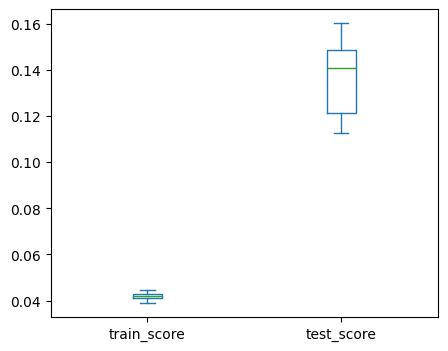

In [45]:
lgbm_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', LGBMRegressor(random_state=0))
])

lgbm_score = cross_validate(lgbm_pipeline, X_train, np.log(1+y_train),
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

plot_rmse(lgbm_score)
print(f"mean: {np.sqrt(-lgbm_score['test_score']).mean()}")

## Hyperparameter optimisation

In [38]:
def objective(trial):

    params = {
        "objective": "regression",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model_pipeline = Pipeline([
        ('total', total_pipeline),
        ('model', LGBMRegressor(**params, random_state=0))
    ])
    
    score = cross_val_score(model_pipeline, X_train, np.log(1+y_train),
                            scoring='neg_mean_squared_error')
    return score.mean()

In [39]:
# may not be reproducible but that's ok
study = optuna.create_study(
    direction='maximize'
)

study.optimize(objective, n_trials=30, n_jobs=-1)

[I 2023-07-09 22:57:20,257] A new study created in memory with name: no-name-21ba447c-67cc-4032-818d-3a86d7fe8338
[I 2023-07-09 22:58:00,328] Trial 6 finished with value: -0.04458887470918882 and parameters: {'learning_rate': 0.003318683967250581, 'num_leaves': 528, 'subsample': 0.19677242319583754, 'colsample_bytree': 0.9291486259242208, 'min_data_in_leaf': 75}. Best is trial 6 with value: -0.04458887470918882.
[I 2023-07-09 22:58:14,667] Trial 4 finished with value: -0.021963434183120103 and parameters: {'learning_rate': 0.09787919091904668, 'num_leaves': 967, 'subsample': 0.6218210651127336, 'colsample_bytree': 0.2934731565709278, 'min_data_in_leaf': 90}. Best is trial 4 with value: -0.021963434183120103.
[I 2023-07-09 22:58:16,248] Trial 0 finished with value: -0.023532459976273182 and parameters: {'learning_rate': 0.00571369602278916, 'num_leaves': 707, 'subsample': 0.3827742389582143, 'colsample_bytree': 0.5937786871418698, 'min_data_in_leaf': 51}. Best is trial 4 with value: -0.

In [40]:
study.best_params

{'learning_rate': 0.008898951387523906,
 'num_leaves': 12,
 'subsample': 0.8300474397273252,
 'colsample_bytree': 0.7228360502352134,
 'min_data_in_leaf': 2}

In [41]:
np.sqrt(-study.best_value)

0.1292758244191126

In [46]:
selected_hyperp = {
    "objective": "regression",
    "n_estimators": 1000,
    "verbosity": -1,
    "bagging_freq": 1,
    'learning_rate': 0.008898951387523906,
    'num_leaves': 12,
    'subsample': 0.8300474397273252,
    'colsample_bytree': 0.7228360502352134,
    'min_data_in_leaf': 2,
    'random_state': SEED
}

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Cu

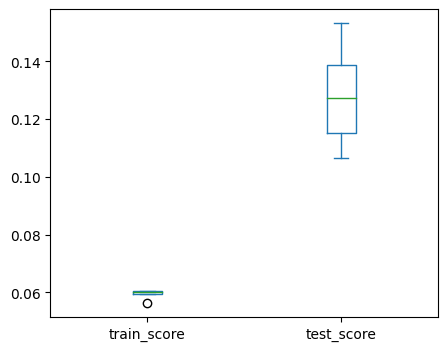

In [47]:
lgbm_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', LGBMRegressor(**selected_hyperp))
])

lgbm_score = cross_validate(lgbm_pipeline, X_train, np.log(1+y_train),
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

plot_rmse(lgbm_score)
print(f"mean: {np.sqrt(-lgbm_score['test_score']).mean()}")

## Scoring pipeline

In [48]:
X_test, y_test = test.drop('SalePrice', axis=1), test['SalePrice']

In [49]:
model_pipeline = Pipeline([
    ('total', total_pipeline),
    ('model', LGBMRegressor(**selected_hyperp))
])

In [50]:
model_pipeline

Pipeline(steps=[('total',
                 Pipeline(steps=[('fc',
                                  Pipeline(steps=[('impute_none',
                                                   CategoricalImputer(fill_value='None',
                                                                      ignore_format=True,
                                                                      return_object=True,
                                                                      variables=['Alley',
                                                                                 'BsmtQual',
                                                                                 'BsmtCond',
                                                                                 'BsmtExposure',
                                                                                 'BsmtFinType1',
                                                                                 'BsmtFinType2',
                                                                                 'FireplaceQu',
                                                                                 'GarageType',
                                                                                 'GarageFinish',
                                                                                 'GarageQual',
                                                                                 'GarageCond',
                                                                                 'PoolQC',
                                                                                 'Fence',
                                                                                 'MiscFeature'])),
                                                  ('impute_...
                                                   SmartCorrelatedSelection(estimator=DecisionTreeRegressor(random_state=0),
                                                                            scoring='neg_mean_squared_error',
                                                                            selection_method='model_performance'))]))])),
                ('model',
                 LGBMRegressor(bagging_freq=1,
                               colsample_bytree=0.7228360502352134,
                               learning_rate=0.008898951387523906,
                               min_data_in_leaf=2, n_estimators=1000,
                               num_leaves=12, objective='regression',
                               random_state=0, subsample=0.8300474397273252,
                               verbosity=-1))])

In [51]:
X_test[impute_zero_vars+impute_from_other_vars+impute_median_vars] = X_test[impute_zero_vars+impute_from_other_vars+impute_median_vars].astype('float')
X_test[impute_none_vars+impute_mode_vars] = X_test[impute_none_vars+impute_mode_vars].astype('object')

In [52]:
model_pipeline.fit(X_train, np.log(1+y_train))

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Pipeline(steps=[('total',
                 Pipeline(steps=[('fc',
                                  Pipeline(steps=[('impute_none',
                                                   CategoricalImputer(fill_value='None',
                                                                      ignore_format=True,
                                                                      return_object=True,
                                                                      variables=['Alley',
                                                                                 'BsmtQual',
                                                                                 'BsmtCond',
                                                                                 'BsmtExposure',
                                                                                 'BsmtFinType1',
                                                                                 'BsmtFinType2',
                                                                                 'FireplaceQu',
                                                                                 'GarageType',
                                                                                 'GarageFinish',
                                                                                 'GarageQual',
                                                                                 'GarageCond',
                                                                                 'PoolQC',
                                                                                 'Fence',
                                                                                 'MiscFeature'])),
                                                  ('impute_...
                                                   SmartCorrelatedSelection(estimator=DecisionTreeRegressor(random_state=0),
                                                                            scoring='neg_mean_squared_error',
                                                                            selection_method='model_performance'))]))])),
                ('model',
                 LGBMRegressor(bagging_freq=1,
                               colsample_bytree=0.7228360502352134,
                               learning_rate=0.008898951387523906,
                               min_data_in_leaf=2, n_estimators=1000,
                               num_leaves=12, objective='regression',
                               random_state=0, subsample=0.8300474397273252,
                               verbosity=-1))])

In [53]:
y_pred = model_pipeline.predict(X_test)

In [54]:
# test performance according to kaggle metric
np.sqrt(mean_squared_error(np.log(1+y_test), y_pred))

0.11611235328395171

In [55]:
# test rmse
np.sqrt(mean_squared_error(y_test, np.exp(y_pred)-1))

34364.03935759033

For Kaggle

In [51]:
X_holdout = pd.read_csv('../data/test.csv', index_col=False)

In [52]:
y_holdout_pred = model_pipeline.predict(X_holdout)

In [55]:
pd.concat([X_holdout['Id'], pd.DataFrame({'SalePrice': np.exp(y_holdout_pred)-1})], axis=1).to_csv('kaggle_submission_5.csv', index=False)